# Importing Libraries and Dataset

In [752]:
###Importing Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

In [753]:
###Importing Data
df=pd.read_csv("Data.csv")

In [754]:
df.head()

,Country-Pair,OriginCountry,DestinCountry,Year,Month,Time_Attribute,PassengerCount,DataType
0,IN-IN,IN,IN,2009,1,2009_1,1857766.89,actuals
1,IN-IN,IN,IN,2009,2,2009_2,1830954.87,actuals
2,IN-IN,IN,IN,2009,3,2009_3,1776478.68,actuals
3,IN-IN,IN,IN,2009,4,2009_4,1745262.69,actuals
4,IN-IN,IN,IN,2009,5,2009_5,2163886.03,actuals


In [755]:
df['Country-Pair'].unique()

array(['IN-IN', 'US-IN', 'IN-US', 'US-US'], dtype=object)

# Data Preprocessing & Analysis

In [756]:
def splitdata(data,var):
    data_split=df[df['Country-Pair'] == var]
    df_actual=data_split[data_split['DataType'] == 'actuals']
    df_train=pd.DataFrame(df_actual.iloc[:,6])
    df_forecast=data_split[data_split['DataType'] == 'forecasted']
    return df_actual,df_train,df_forecast
    

In [757]:
df_actual,df_model,df_forecast=splitdata(df,'IN-US')

In [758]:
split_point = len(df_model) - 12
df_train, df_valid = df_model[0:split_point], df_model[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

Dataset 57, Validation 12


## Line Plot

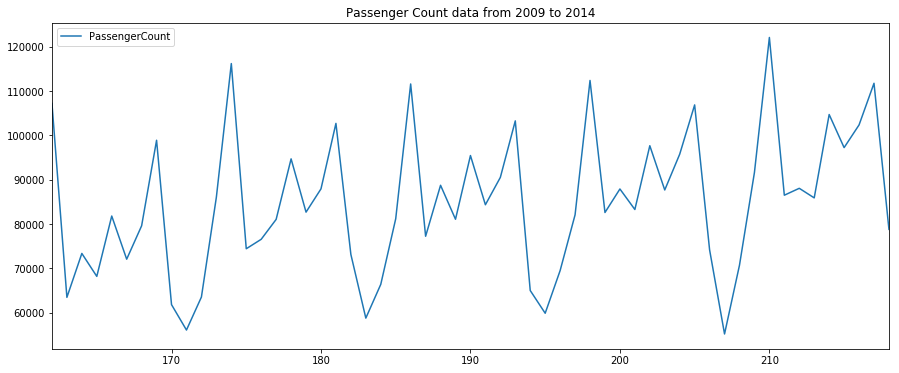

In [759]:
df_train.plot(figsize=(15, 6),title="Passenger Count data from 2009 to 2014")
plt.show()

Reviewing the line plot, it suggests that there may be a linear trend, but it is hard to be sure from eye-balling. <br>
There is also seasonality, but the amplitude (height) of the cycles appears to be constant, suggesting that it is additive.

**We will assume a Additive model.**

## Time Series Analysis – Decomposition

$ Y_{t} = f(Trend_{t}\ , Seasonality_{t}\ , Remainder_{t}) $

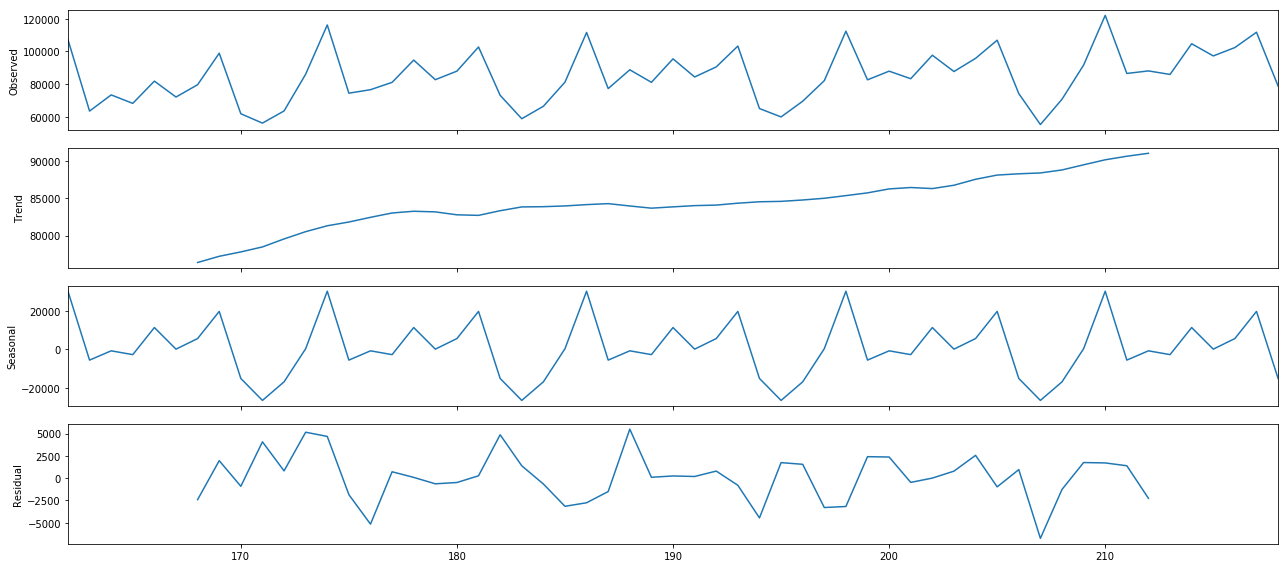

In [760]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_train, model='additive',freq=12)
fig = decomposition.plot()
plt.show()

### Some observations from the plot include:

- There is an increasing trend of Passenger Count over time.<br>
- There do not appear to be any obvious outliers.<br>
- The fluctuations appear to be similar across the years.,means there is seasonlity in the dataset.<br>
- The trend means the dataset is almost certainly non-stationary and the apparent change in fluctuation may also contribute.

# Stationary test of time series

1. Test stationarity of the time series (ADF)

In order to test the stationarity of the time series, let’s run the Augmented Dickey-Fuller Test using the adf.test function from the tseries R package.

First set the hypothesis test:

The null hypothesis H0 : that the time series is non stationary
The alternative hypothesis HA : that the time series is stationary

In [761]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Augmented Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    df_test = adfuller(df_train['PassengerCount'], autolag='AIC')

    df_output = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

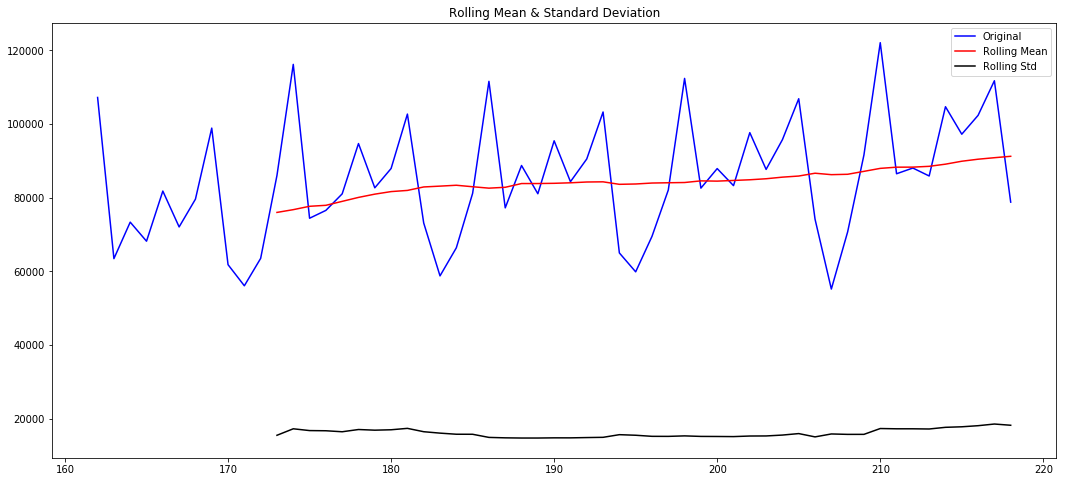

Results of Dickey Fuller Test:
Test Statistic                 -1.153448
p-value                         0.693294
#Lags Used                     11.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64


In [762]:
test_stationarity(df_train)

For a Time series to be stationary, its ADCF test should have:

p-value to be low (According to the null hypothesis)
The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics
From the above ADCF test result, we see that p-value is very large. Also critical values are no where close to the Test Statistics. <br>
Hence, we can safely say that our Time Series at the moment is not stationary

### Plotting ACF & PACF


c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


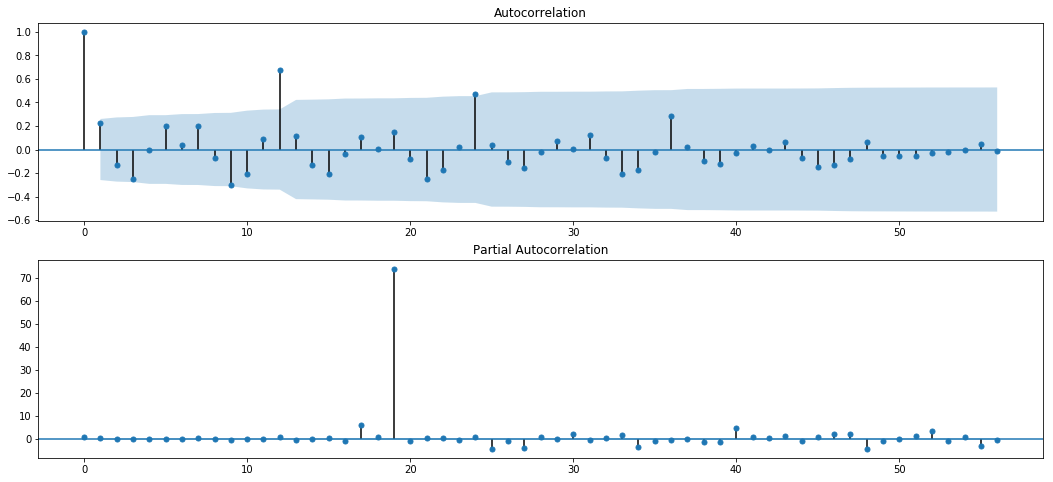

In [763]:
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

pyplot.figure()
pyplot.subplot(211)
plot_acf(df_train, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(df_train, ax=pyplot.gca())
pyplot.show()

# Model Building ~ Auto Arima

In [764]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(df_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=887.078, BIC=890.646, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=885.915, BIC=893.052, Fit time=0.123 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=887.447, BIC=892.800, Fit time=0.031 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=886.274, BIC=895.195, Fit time=0.385 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=884.333, BIC=889.686, Fit time=0.094 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=886.276, BIC=893.413, Fit

In [765]:
stepwise_model.fit(df_train)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 1, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

## Prediction

In [766]:
df_predict = stepwise_model.predict(n_periods=len(df_valid))
df_predict = pd.DataFrame(df_predict,index = df_valid.index,columns=['Prediction'])

In [767]:
df_predict

,Prediction
219,61328.644410
220,76064.051903
221,95903.082273
222,126254.276226
223,91242.337752
224,93134.545864
225,90586.804769
226,108782.212384
227,100923.141252
228,106287.090903


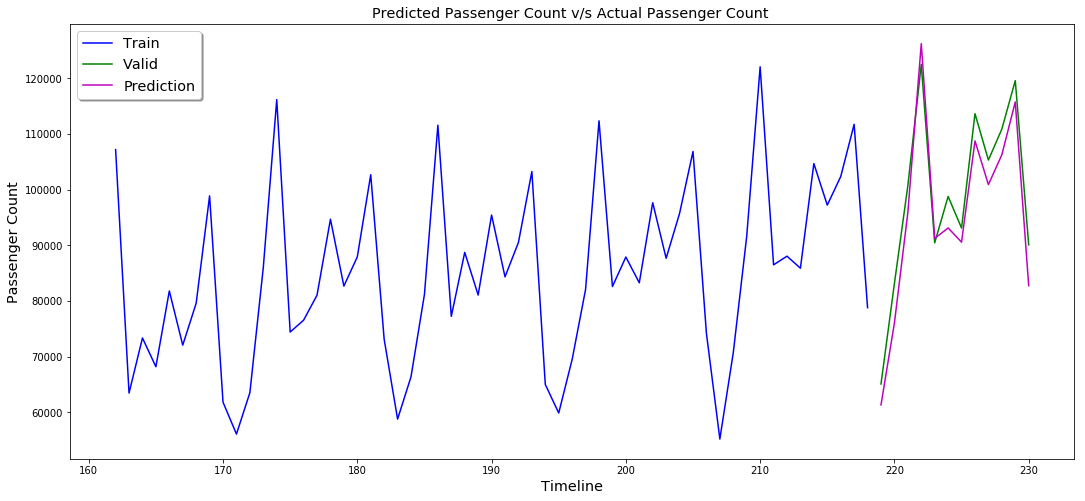

In [768]:
#plot the predictions for validation set
plt.plot(df_train,color='b',label='Train')
plt.plot(df_valid,color='g',label='Valid')
plt.plot(df_predict,color='m',label='Prediction')
plt.xlabel('Timeline',fontsize='x-large')
plt.ylabel('Passenger Count',fontsize='x-large')
plt.title('Predicted Passenger Count v/s Actual Passenger Count ',fontsize='x-large')
plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.show()

# Performance Measure

In [769]:
#calculate rmse
from math import sqrt
from sklearn.metrics import mean_squared_error

rms = sqrt(mean_squared_error(df_valid,df_predict))
print('RMSE: %.3f' % rms)

RMSE: 4778.613


# Forecasting

In [770]:
stepwise_model = auto_arima(df_model, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,test="adf")
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1122.501, BIC=1126.551, Fit time=0.040 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1119.963, BIC=1128.064, Fit time=0.159 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1118.835, BIC=1126.937, Fit time=0.136 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1119.136, BIC=1129.263, Fit time=0.322 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1122.710, BIC=1128.786, Fit time=0.145 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=1117.241, BIC=1123.318, Fit time=0.084 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=111

In [771]:
import time
start = time.time()

future_forecast = stepwise_model.predict(n_periods=12)
future_forecast = pd.DataFrame(future_forecast,columns=['PassengerCount'])

end = time.time()
print(end - start)

0.011984586715698242


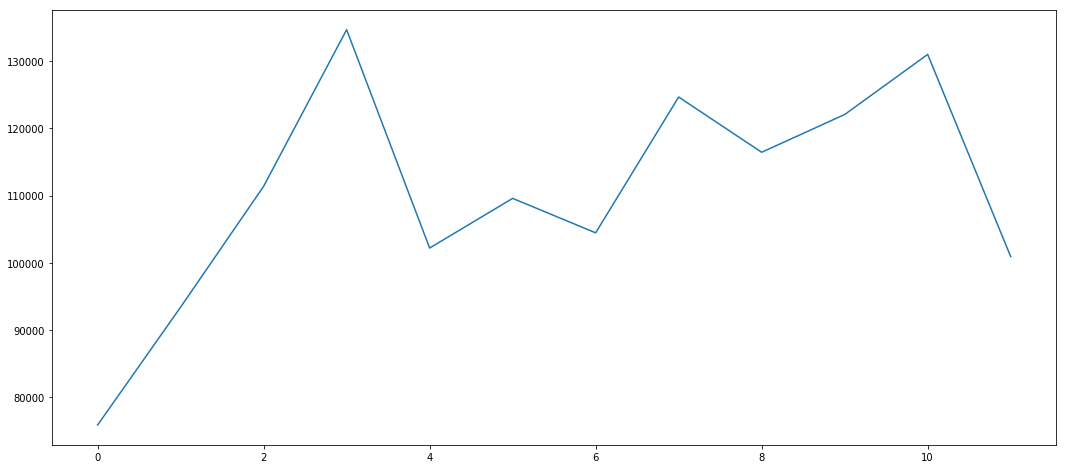

In [772]:
plt.plot(future_forecast, label='PassengerCount')
plt.show()

In [773]:
df_forecast['PassengerCount'] = list(future_forecast['PassengerCount'])

In [774]:
df_forecast

,Country-Pair,OriginCountry,DestinCountry,Year,Month,Time_Attribute,PassengerCount,DataType
231,IN-US,IN,US,2014,10,2014_10,75901.399925,forecasted
232,IN-US,IN,US,2014,11,2014_11,93425.957093,forecasted
233,IN-US,IN,US,2014,12,2014_12,111383.585861,forecasted
234,IN-US,IN,US,2015,1,2015_1,134670.396510,forecasted
235,IN-US,IN,US,2015,2,2015_2,102209.930849,forecasted
236,IN-US,IN,US,2015,3,2015_3,109595.375980,forecasted
237,IN-US,IN,US,2015,4,2015_4,104471.448937,forecasted
238,IN-US,IN,US,2015,5,2015_5,124662.169783,forecasted
239,IN-US,IN,US,2015,6,2015_6,116450.250681,forecasted
240,IN-US,IN,US,2015,7,2015_7,122061.232055,forecasted


In [775]:
df_actual=df_actual.append(df_forecast)

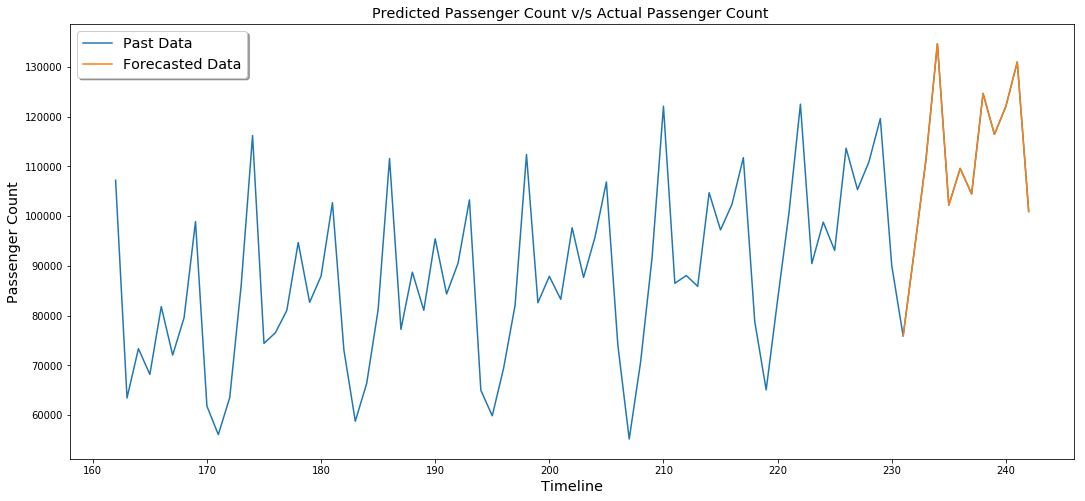

In [776]:
#plot the predictions for validation set
plt.plot(df_actual['PassengerCount'], label='Past Data')
plt.plot(df_forecast['PassengerCount'], label='Forecasted Data')
plt.xlabel('Timeline',fontsize='x-large')
plt.ylabel('Passenger Count',fontsize='x-large')
plt.title('Predicted Passenger Count v/s Actual Passenger Count ',fontsize='x-large')
plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.show()


# #plot the predictions for validation set
# plt.plot(df_train,color='b',label='Train')
# plt.plot(df_valid,color='g',label='Valid')
# plt.plot(df_predict,color='m',label='Prediction')
# plt.xlabel('Timeline',fontsize='x-large')
# plt.ylabel('Passenger Count',fontsize='x-large')
# plt.title('Predicted Passenger Count v/s Actual Passenger Count ',fontsize='x-large')
# plt.legend(loc='upper left', shadow=True, fontsize='x-large')
# plt.show()

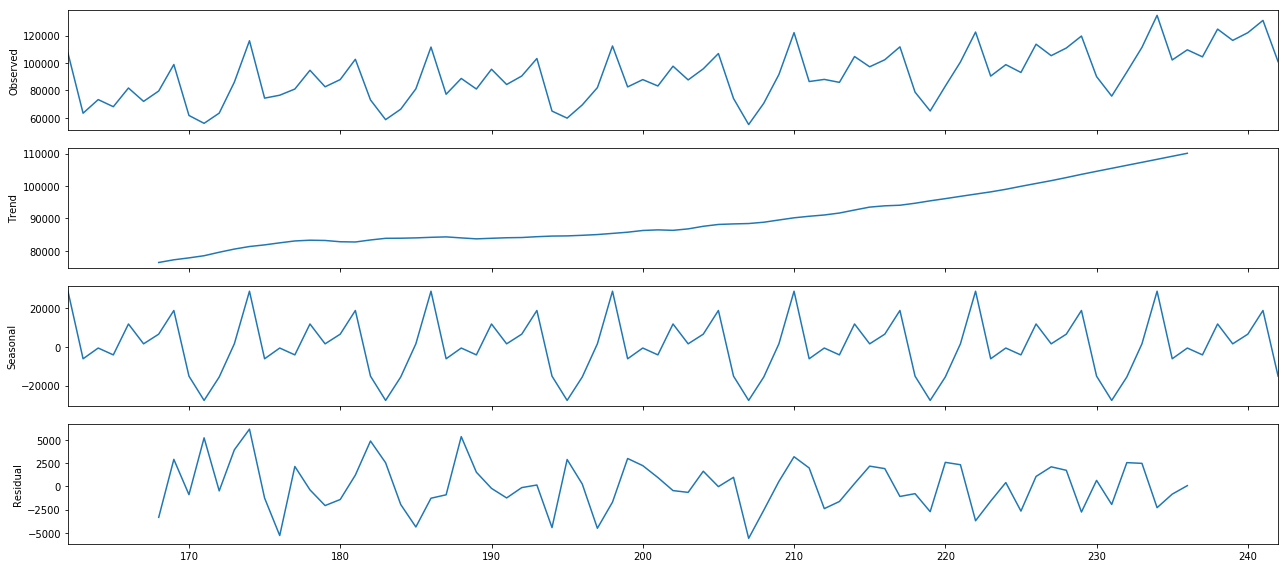

In [777]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_actual['PassengerCount'], model='additive',freq=12)
fig = decomposition.plot()
plt.show()

## Consolidating all the forecasted data with actual data

In [778]:
Data=Data.append(df_actual)


In [779]:
Data.tail()

,Country-Pair,OriginCountry,DestinCountry,Year,Month,Time_Attribute,PassengerCount,DataType
238,IN-US,IN,US,2015,5,2015_5,124662.169783,forecasted
239,IN-US,IN,US,2015,6,2015_6,116450.250681,forecasted
240,IN-US,IN,US,2015,7,2015_7,122061.232055,forecasted
241,IN-US,IN,US,2015,8,2015_8,130993.901501,forecasted
242,IN-US,IN,US,2015,9,2015_9,100938.651706,forecasted


In [780]:
###Write a csv file with forecated values

Data.to_csv('Dataforecasted.csv')

# Answers to Questions --
• Is the data suitable for solving the business problem? Why or why not?<br>
**Ans -- Data is suitable for business problem because the way it is structured.Seasonality was clearly observable and removable, so series become stationary, if the value of given data were different then we could have required more data to analyse the series**

• How do you measure model performance?
**Ans -- Using RMSE**

• What is the time (analysis time) that needs to
spend per country-pair? Note: lower the better
• What is the run-time per country-pair? Note:
lower the better<br>
**Ans --
Country.Pair	Analysis Time	Run Time<br>
IN-IN	2.239 seconds	0.0101 seconds<br>
US-IN	6.318 seconds	0.012 seconds<br>
IN-US	1.137 seconds	0.0079 seconds<br>
US-US	0.498 seconds	0.0119 seconds**

![title](timeanalysis.png)
